In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import numpy as np
import os

In [9]:
base_path_structured = "/Users/benhoskings/Documents/Datasets/Fusion"
train_path_structured = os.path.join(base_path_structured, "train_set")

class_names = ["Anger", "Disgust", "Happy", "Neutral", "Fear", "Sad", "Surprise"]
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path_structured, 
    class_names=class_names,
    label_mode="categorical", 
    labels="inferred", 
    validation_split=0.05, 
    subset="both", 
    batch_size=64,
    image_size=(299, 299),
    seed=101)

Found 40621 files belonging to 7 classes.
Using 38590 files for training.
Using 2031 files for validation.


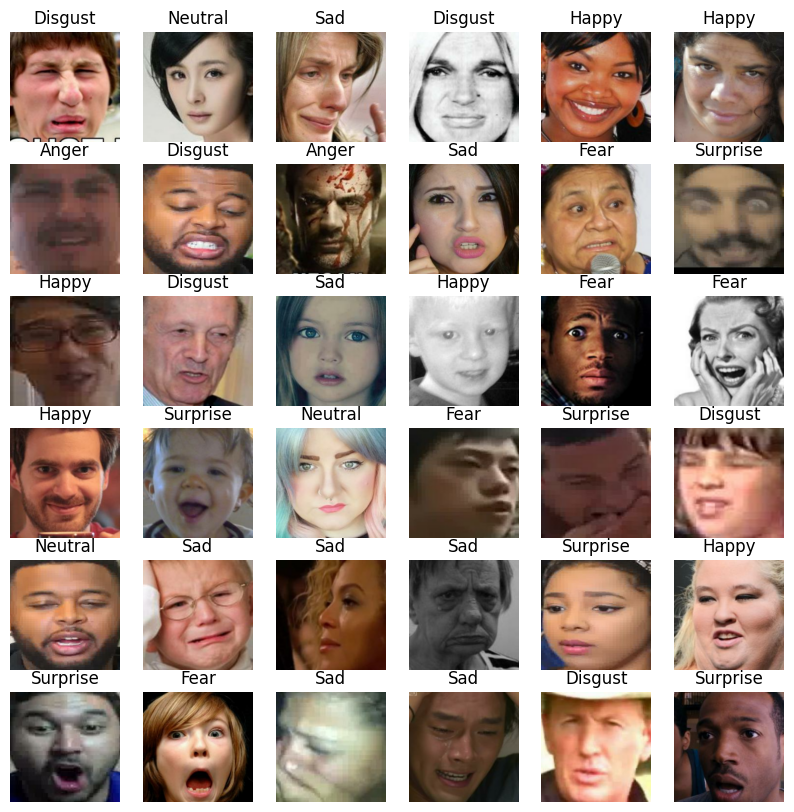

In [10]:
batch_size = 64
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(36):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
        
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
validation_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

2023-11-14 10:18:06.082348: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


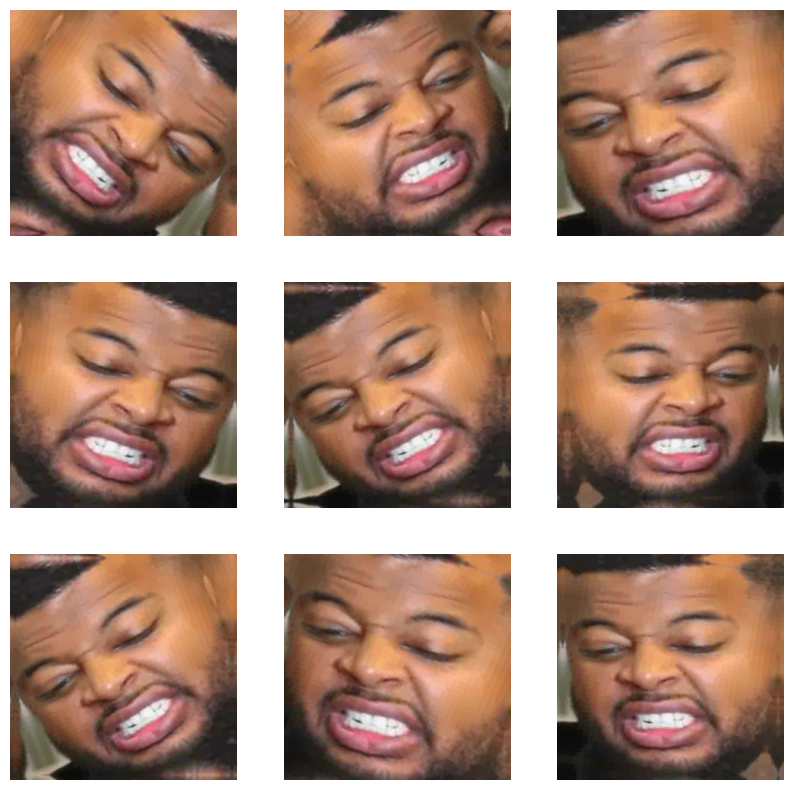

In [11]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

In [12]:
base_model = keras.applications.InceptionResNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Xception uses size (150, 150) - 23M
# InceptionResV2 uses size (299, 299) - Bigger model 56M

# Freeze the base_model
base_model.trainable = False

In [13]:
# Create new model on top
if load_model
inputs = keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Inception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(7)(x)
model = keras.Model(inputs, outputs)

# SPECIFY LEARNING RATE
base_learning_rate = 0.001

model.summary()
model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=base_learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()],
)
init_epochs = 20

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 inception_resnet_v2 (Funct  (None, 8, 8, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1536)              0   

In [ ]:
train_history = model.fit(train_ds, epochs=init_epochs, validation_data=validation_ds)

Epoch 1/20
603/603 [==============================] - 1861s 3s/step - loss: 0.3849 - categorical_accuracy: 0.3155 - val_loss: 0.3711 - val_categorical_accuracy: 0.3516
Epoch 2/20
603/603 [==============================] - 1919s 3s/step - loss: 0.3618 - categorical_accuracy: 0.3831 - val_loss: 0.3612 - val_categorical_accuracy: 0.3742
Epoch 3/20
603/603 [==============================] - 1829s 3s/step - loss: 0.3551 - categorical_accuracy: 0.3992 - val_loss: 0.3536 - val_categorical_accuracy: 0.3949
Epoch 4/20
603/603 [==============================] - 1830s 3s/step - loss: 0.3529 - categorical_accuracy: 0.4053 - val_loss: 0.3543 - val_categorical_accuracy: 0.3929
Epoch 5/20
603/603 [==============================] - 1835s 3s/step - loss: 0.3503 - categorical_accuracy: 0.4101 - val_loss: 0.3516 - val_categorical_accuracy: 0.3973
Epoch 6/20
603/603 [==============================] - 3118s 5s/step - loss: 0.3497 - categorical_accuracy: 0.4133 - val_loss: 0.3491 - val_categorical_accuracy:

In [ ]:
model.save('AffectInceptionResNetV2.keras')

In [ ]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

epochs_range = range(init_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Number of layers to fine tune
fine_tune_final = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[len(base_model.layers) - fine_tune_final:]:
  layer.trainable = False
  
model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=base_learning_rate/10),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

len(model.trainable_variables)

fine_tune_epochs = 10
total_epochs =  init_epochs + fine_tune_epochs

In [ ]:
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=train_history.epoch[-1],
                         validation_data=val_ds)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([init_epochs-1,init_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([init_epochs-1,init_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
img = tf.keras.utils.load_img("Affective_Computing/Sample_Images/Ben Glasses.png", target_size=(299, 299))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

scores = model.decode_predictions(
    predictions
)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)